In [0]:
%%capture
!pip install --upgrade --force-reinstall --no-deps albumentations

In [0]:
%%capture
import shutil
shutil.copy('/content/drive/My Drive/Global Wheat Detection/global-wheat-detection.zip', '/content/global-wheat-detection.zip')
!unzip '/content/global-wheat-detection.zip'

In [0]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations.augmentations.transforms import Flip, RandomBrightnessContrast, HueSaturationValue, VerticalFlip, Resize
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt

In [0]:
image_list = os.listdir(os.path.join('/content', 'train'))
# n = round(len(image_list)*0.8)
# train_list = image_list[:n]
# val_list = image_list[n:]

In [0]:
class WheatDataset(Dataset):
  def __init__(self, path, image_list, transforms=None, train=True):
    self.path = path
    self.df = pd.read_csv(os.path.join(self.path, 'train.csv'))
    self.image_list  = image_list     
    self.transforms = transforms
    self.train = train

  @staticmethod
  def format_boxes(box):
    box = box[1:-1].split(',')
    box_ = []
    for i in box:
      temp = i.split('.')[0]
      temp = float(temp)
      box_.append(temp)
    # box_[2] = box_[0] + box_[2]
    # box_[3] = box_[1] + box_[3]
    return box_

  @staticmethod
  def format_areas(box):
    area = box[2]*box[3]
    # area = (box[2] - box[0]) * (box[3] - box[1])
    return area

  def __len__(self):
    return len(self.image_list)

  def __getitem__(self, idx):
    image_name = self.image_list[idx]
    image = cv2.imread(os.path.join(self.path, 'train', image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    record = self.df[self.df['image_id'] == image_name[:-4]]
    boxes = []
    areas = []
    for i in range(len(record)):
      box = self.format_boxes(record.iloc[i]['bbox'])
      area = self.format_areas(box)
      boxes.append(box)
      areas.append(area)
    
    labels = torch.ones(len(record))
    iscrowd = torch.zeros(len(record))

    target = {}
    target['boxes'] = torch.tensor(boxes)
    target['labels'] = labels
    target['image_id'] = torch.tensor([idx])
    target['area'] = torch.tensor(areas)
    target['iscrowd'] = iscrowd

    if self.transforms:
      sample = {'image': image,
                'bboxes': target['boxes'],
                'labels': labels
                }
      sample = self.transforms(**sample)
      image = sample['image']
      target['boxes'] = torch.tensor(sample['bboxes'])

    if not self.train:
      tr = A.Compose([ToTensorV2(p=1.0)], bbox_params={'format':'coco', 'label_fields':['labels']})
      sample = {'image': image,
                'bboxes': target['boxes'],
                'labels': labels
                }
      sample = tr(**sample)
      image = sample['image']
      target['boxes'] = torch.tensor(sample['bboxes'])

    return image, target

def collate(batch):
  return tuple(zip(*batch))

In [0]:
def train_aug():
  return A.Compose([A.Flip(), A.RandomBrightnessContrast(), A.HueSaturationValue(hue_shift_limit=0.5, sat_shift_limit= 0.5, val_shift_limit=0.5, p=0.5),
                    ToTensorV2(p=1.0)], bbox_params={'format':'coco', 'label_fields':['labels']})

In [0]:
def detection_box(images, targets):
  for i in range(len(images)):
    plt.figure()
    img = images[i].permute(1,2,0).numpy()
    tar = targets[i]
    boxes = tar['boxes'].data.numpy().astype(np.int32)
    for box in boxes:
      x0 = box[0]
      y0 = box[1]
      x1 = box[0]+box[2]
      y1 = box[1]+box[3]
      cv2.rectangle(img, (x0, y0), (x1, y1), color=(255,0,0), thickness=3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


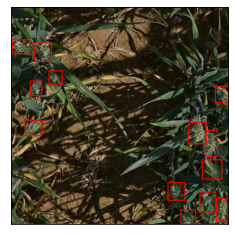

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


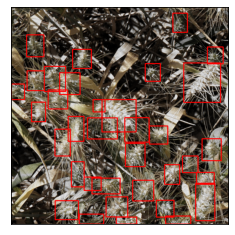

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


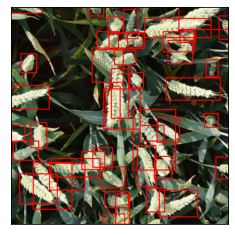

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


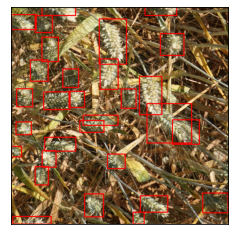

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


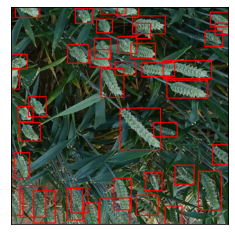

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


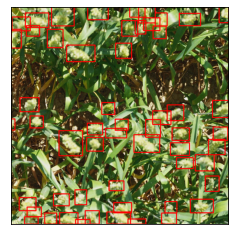

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


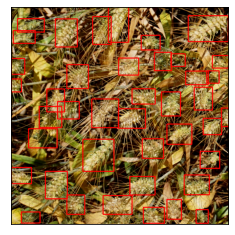

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


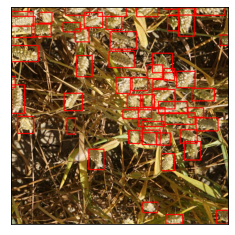

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


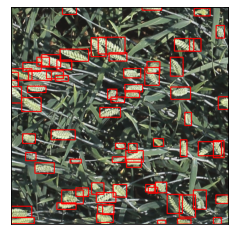

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


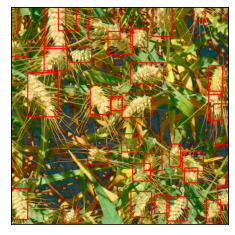

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


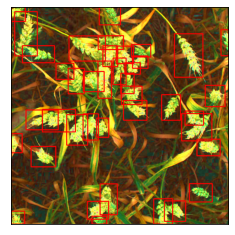

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


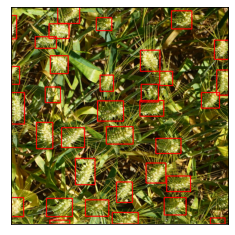

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


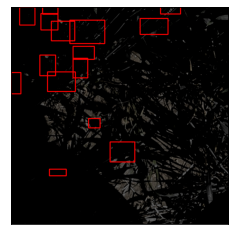

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


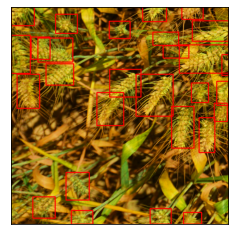

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


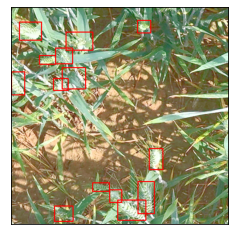

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


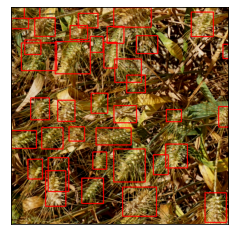

In [13]:
data = WheatDataset('/content', image_list, train_aug())
train_data_loader = DataLoader(data,batch_size=16,shuffle=False,num_workers=4,collate_fn=collate)
imm, tar = next(iter(train_data_loader))
detection_box(imm, tar)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

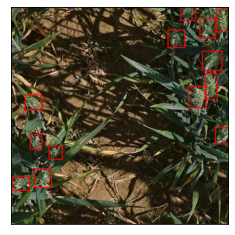

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


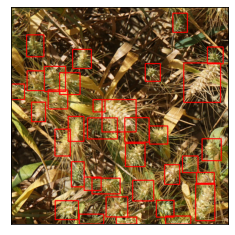

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


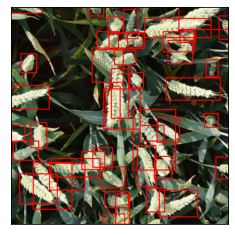

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


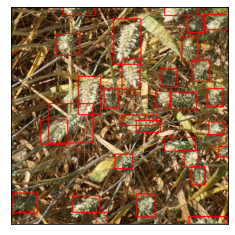

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


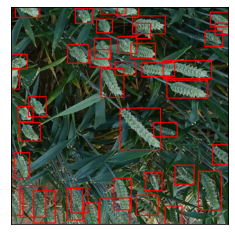

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


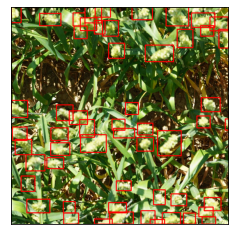

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


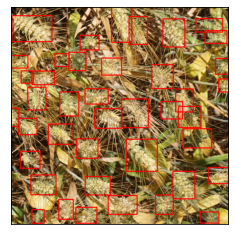

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


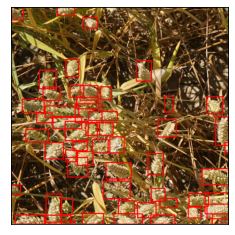

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


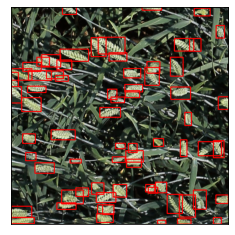

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


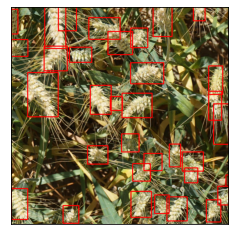

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


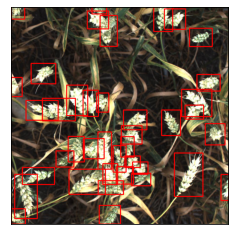

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


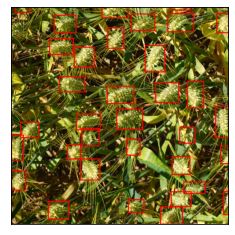

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


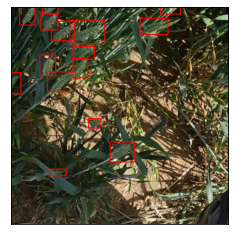

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


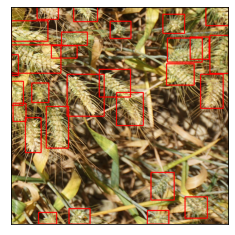

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


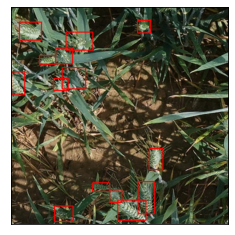

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


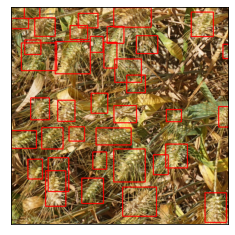

In [14]:
valid_data = WheatDataset('/content', image_list, train=False)
valid_data_loader = DataLoader(valid_data,batch_size=16,shuffle=False,num_workers=4,collate_fn=collate)
imm, tar = next(iter(valid_data_loader))
detection_box(imm, tar)